In [1]:
# import library here

# Data preprocessing

From the EDA, the following data processing is required: 
- Normalized the color?
- Data augmentation:
    When working with medical image data, data augmentation should be carefully considered to avoid introducing false information. However, as the dataset is related to cell-type structure, flipping and rotating are acceptable as the overall structure is not affected. This is also the technique that is used in the paper **REF**. 

Since the pixel is has the value from 0-255, to avoid the scenario of having domninant terms affect the calculation, running normamlize to 0-1 is used.
REF: https://www.tensorflow.org/tutorials/images/classification (Section using ReScaling)

In [2]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import numpy as np
from tensorflow.keras.layers import Rescaling

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 27
IMG_WIDTH = 27

In [4]:
# Set up output directories
output_train_dir = "./data/preprocessed/train"
output_test_dir = "./data/preprocessed/test"
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

## Running normalization

In [5]:
# Define Keras normalization layer
normalization_layer = Rescaling(1./255)

# Define preprocessing function
def preprocess_image(image_path, image_size=(27, 27)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    image = normalization_layer(image)  # Apply Keras rescaling
    return image

# Function to save image
def save_image(tensor, path):
    # Convert to uint8 for saving
    array = (tensor.numpy() * 255).astype(np.uint8)
    image = Image.fromarray(array)
    image.save(path)

def scale_images_in_splitted(data, output_dir, default_path='./data/patch_images/', default_img_name_col='ImageName'):
    data['ImagePath'] = ''
    for idx, row in data.iterrows():
        image_path = default_path + row[default_img_name_col]
        image_tensor = preprocess_image(image_path)
        filename = os.path.basename(row[default_img_name_col])
        output_path = os.path.join(output_dir, filename)
        save_image(image_tensor, output_path)
        data.at[idx, 'ImagePath'] = os.path.join(output_dir, filename)

    return data

In [6]:
train_data = pd.read_csv('./data/train.csv')
train_data = scale_images_in_splitted(train_data, output_train_dir)

In [7]:
test_data = pd.read_csv('./data/test.csv')
scale_images_in_splitted(test_data, output_test_dir)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,ImagePath
0,22405,1,22405.png,fibroblast,0,0,./data/preprocessed/test/22405.png
1,22406,1,22406.png,fibroblast,0,0,./data/preprocessed/test/22406.png
2,22407,1,22407.png,fibroblast,0,0,./data/preprocessed/test/22407.png
3,22408,1,22408.png,fibroblast,0,0,./data/preprocessed/test/22408.png
4,22409,1,22409.png,fibroblast,0,0,./data/preprocessed/test/22409.png
...,...,...,...,...,...,...,...
2123,3931,52,3931.png,epithelial,2,1,./data/preprocessed/test/3931.png
2124,3932,52,3932.png,epithelial,2,1,./data/preprocessed/test/3932.png
2125,3935,52,3935.png,epithelial,2,1,./data/preprocessed/test/3935.png
2126,3936,52,3936.png,epithelial,2,1,./data/preprocessed/test/3936.png


## Handle imbalance on train dataset

As mentioned in the EDA section, the dataset is imbalanced,

In [8]:
data = train_data.copy()
data['combined_label'] = data['cellType'].astype(str) + '_' + data['isCancerous'].astype(str)

column_data = {col: data[col].astype(str).values for col in data.columns}
column_data['isCancerous'] = data['isCancerous'].astype(int).values

ds = tf.data.Dataset.from_tensor_slices(column_data)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

def plot_categorical_distribution(data):
    # Prepare data
    cell_type_counts = data[['cellType', 'cellTypeName']].value_counts().reset_index()
    cell_type_counts.columns = ['cellType', 'cellTypeName', 'Count']
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    
    # Plot 1: Cancerous vs Non-Cancerous
    sns.countplot(x='isCancerous', data=data, ax=axes[0])
    axes[0].set_title('Cancerous vs Non-Cancerous')
    axes[0].set_xticks(list(set(data['isCancerous'].values)))
    axes[0].set_xticklabels(list(set(data['isCancerous'].values)))
    
    # Plot 2: Cell Type Distribution
    sns.barplot(data=cell_type_counts, x="cellTypeName", y="Count", ax=axes[1])
    axes[1].set_title('Cell Type Distribution')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

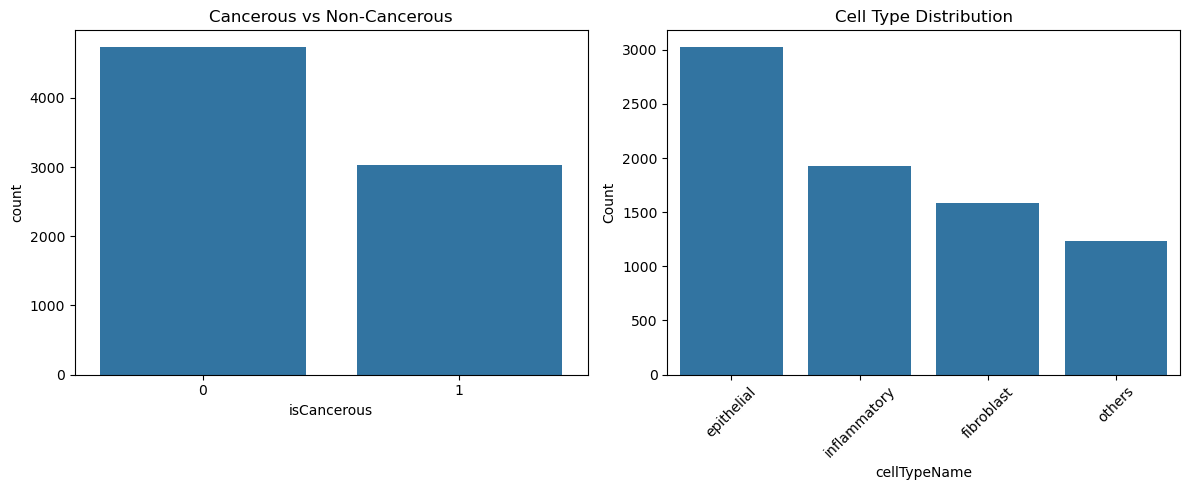

In [10]:
plot_categorical_distribution(train_data)

In [11]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers

# === CONFIGURATION ===
IMG_SIZE = (27, 27)
AUG_BASE_DIR = "./data/augmented"
os.makedirs(AUG_BASE_DIR, exist_ok=True)

# === Load original dataframe and add combined label ===
data = train_data.copy()
data['combined_label'] = data['cellType'].astype(str) + '_' + data['isCancerous'].astype(str)
next_instance_id = data['InstanceID'].astype(int).max() + 1

# === Augmentation pipeline ===
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.15),
    layers.RandomContrast(0.15),
])

# === Helper: Augment sample to generate N images ===
def augment_sample(row, save_dir, count):
    global next_instance_id
    new_records = []
    try:
        img = Image.open(row['ImagePath']).convert('RGB').resize(IMG_SIZE)
        img_tensor = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
    except Exception as e:
        print(f"⚠️ Error reading {row['ImagePath']}: {e}")
        return []

    for _ in range(count):
        augmented = augment(tf.expand_dims(img_tensor, 0))[0]
        filename = f"aug_{row['cellType']}_{row['isCancerous']}_{next_instance_id}.png"
        filepath = os.path.join(save_dir, filename)
        aug_array = tf.cast(augmented * 255, tf.uint8).numpy()
        Image.fromarray(aug_array).save(filepath)

        new_record = row.copy()
        new_record['InstanceID'] = next_instance_id
        new_record['ImageName'] = filename
        new_record['ImagePath'] = filepath
        new_records.append(new_record)
        next_instance_id += 1
    return new_records

# === Task A: Balance isCancerous (preserve cellType proportions) ===
def augment_for_task_a(data, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    target_count = data['isCancerous'].value_counts().max()
    final_records = []
    
    for cancer_class in data['isCancerous'].unique():
        subset = data[data['isCancerous'] == cancer_class]
        counts_by_cell = subset['cellType'].value_counts(normalize=True)
        samples_needed = target_count - len(subset)
        
        aug_records = []
        for cell_type, proportion in counts_by_cell.items():
            sample_count = int(round(samples_needed * proportion))
            candidates = subset[subset['cellType'] == cell_type]
            reps = int(np.ceil(sample_count / len(candidates)))
            
            for _, row in candidates.iterrows():
                if sample_count <= 0:
                    break
                gen = min(reps, sample_count)
                aug_records += augment_sample(row, save_dir, gen)
                sample_count -= gen
        final_records += aug_records

    df_aug = pd.DataFrame(final_records)
    combined = pd.concat([data, df_aug], ignore_index=True)
    return combined

# === Task B: Balance cellType (preserve isCancerous proportions) ===
def augment_for_task_b(data, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    target_count = data['cellType'].value_counts().max()
    final_records = []
    
    for cell_type in data['cellType'].unique():
        subset = data[data['cellType'] == cell_type]
        counts_by_cancer = subset['isCancerous'].value_counts(normalize=True)
        samples_needed = target_count - len(subset)
        
        aug_records = []
        for cancer_class, proportion in counts_by_cancer.items():
            sample_count = int(round(samples_needed * proportion))
            candidates = subset[subset['isCancerous'] == cancer_class]
            reps = int(np.ceil(sample_count / len(candidates)))
            
            for _, row in candidates.iterrows():
                if sample_count <= 0:
                    break
                gen = min(reps, sample_count)
                aug_records += augment_sample(row, save_dir, gen)
                sample_count -= gen
        final_records += aug_records

    df_aug = pd.DataFrame(final_records)
    combined = pd.concat([data, df_aug], ignore_index=True)
    return combined

# === Generate and Save ===

print("\n🔧 Generating Task A Dataset (Balanced isCancerous)...")
task_a_dir = os.path.join(AUG_BASE_DIR, "train_task_a")
task_a_df = augment_for_task_a(data, task_a_dir)
task_a_df.to_csv(os.path.join('./data', "train_is_cancerous.csv"), index=False)
print("✅ Task A done. Class distribution:")
print(task_a_df['isCancerous'].value_counts())

print("\n🔧 Generating Task B Dataset (Balanced cellType)...")
task_b_dir = os.path.join(AUG_BASE_DIR, "train_cell_type")
task_b_df = augment_for_task_b(data, task_b_dir)
task_b_df.to_csv(os.path.join('./data', "train_cell_type.csv"), index=False)
print("✅ Task B done. Class distribution:")
print(task_b_df['cellType'].value_counts())



🔧 Generating Task A Dataset (Balanced isCancerous)...
✅ Task A done. Class distribution:
isCancerous
0    4740
1    4740
Name: count, dtype: int64

🔧 Generating Task B Dataset (Balanced cellType)...
✅ Task B done. Class distribution:
cellType
0    3028
1    3028
3    3028
2    3028
Name: count, dtype: int64


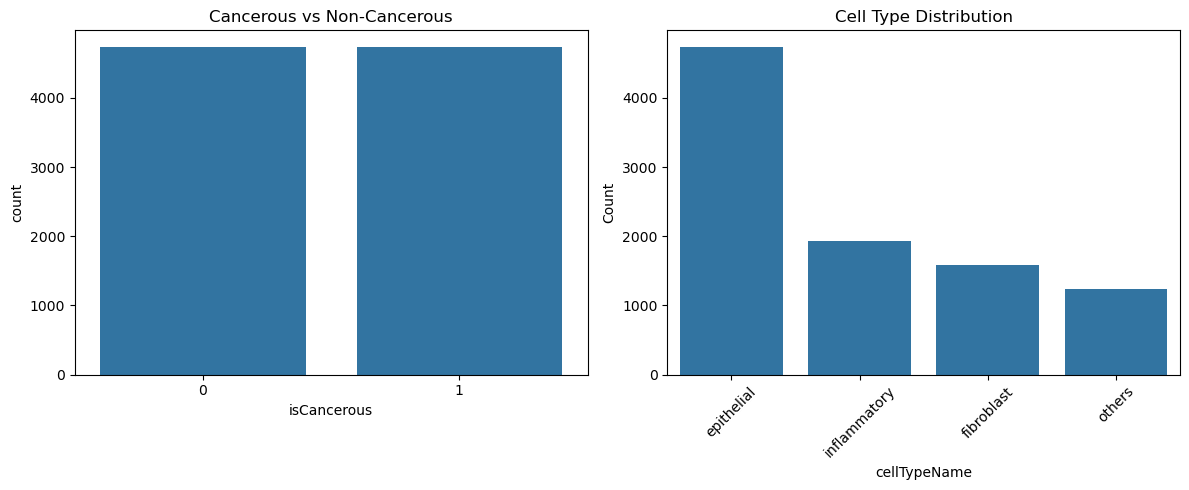

In [12]:
plot_categorical_distribution(task_a_df)

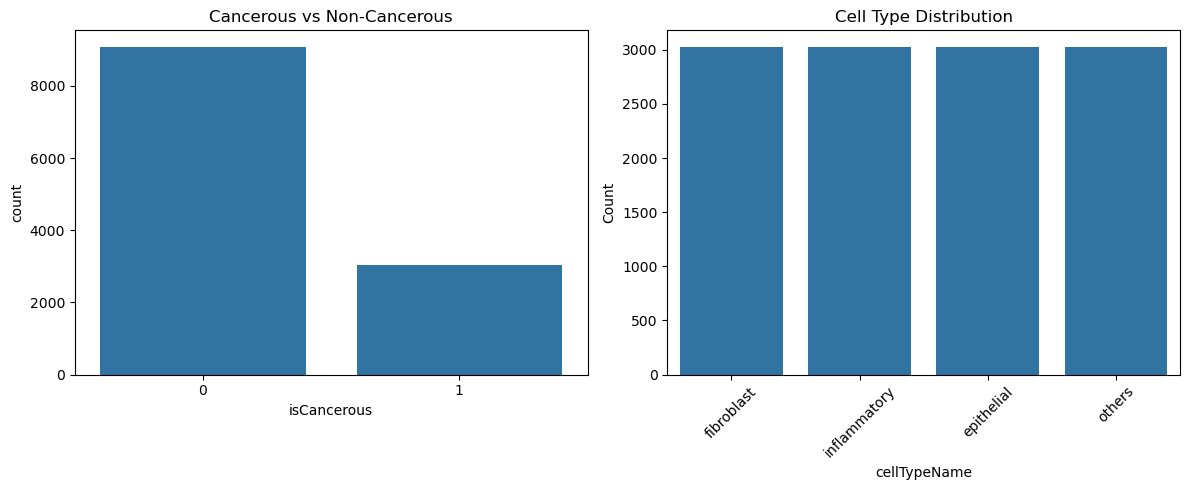

In [13]:
plot_categorical_distribution(task_b_df)